In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

## 1. Load Data

In [250]:
df = pd.read_csv('./data/goalie_stats.csv')
df.head()

,season,name,age,team,games_played,wins,icetime,sv% on unblocked shots,sv% above expected on unblocked shots,sv% on shots on goal,sv% above expected on shots on goal,gaa per 60 min,gsaa per 60 min,war,saves on shots on goal,rebounds per save,freezes per save,goals against,saves on unblocked shot attempts,% of shot attempts blocked by teammates,% of unblocked shot attempts against on goal,on goal % above expected,low danger unblocked shot attempt sv%,low danger unblocked shot attempt sv% above expected,medium danger unblocked shot attempt sv%,medium danger unblocked shot attempt sv% above expected,high danger unblocked shot attempt sv% above expected,corsi,fenwick,win_prob,improvement
0,2008,Craig Anderson,27,FLA,31,15,98154.0,0.956187,0.005909,0.924258,0.010215,2.714102,0.366037,1.663333,903.0,0.071982,0.266888,74.0,1615.0,0.182874,0.578449,0.021285,0.975585,0.005229,0.884921,0.007024,0.040395,2067.0,1689.0,0.483871,0.051340
1,2008,Carey Price,21,MTL,52,23,180336.0,0.949648,-0.002486,0.905486,-0.004666,2.854671,-0.140937,-1.176667,1370.0,0.082482,0.237956,143.0,2697.0,0.211768,0.532746,0.015651,0.971975,0.001166,0.878378,0.000919,-0.067372,3603.0,2840.0,0.442308,-0.125235
2,2008,Chris Osgood,36,DET,46,26,159763.0,0.931637,-0.009501,0.886589,-0.015762,3.087073,-0.429036,-3.173333,1071.0,0.071895,0.230626,137.0,1867.0,0.159748,0.602794,0.018897,0.963744,-0.005084,0.864780,-0.013805,-0.072437,2385.0,2004.0,0.565217,-0.260870
3,2008,Antero Niittymaki,28,PHI,32,15,108255.0,0.952868,0.000619,0.912355,0.001151,2.760150,0.036248,0.181667,864.0,0.086806,0.237269,83.0,1678.0,0.200272,0.537763,0.006053,0.967710,-0.002671,0.881517,0.001517,0.040345,2202.0,1761.0,0.468750,-0.040179
4,2008,Ryan Miller,28,BUF,59,34,202395.0,0.954659,-0.001651,0.918218,-0.002978,2.579115,-0.093915,-0.880000,1628.0,0.053440,0.226658,145.0,3053.0,0.189764,0.554409,0.016701,0.969649,-0.002496,0.886836,0.006397,-0.031238,3947.0,3198.0,0.576271,0.017932


In [252]:
df.shape

(720, 31)

## 2. Simple Feature Selection and Data Modification

There are some features in this dataset that are redundant. In certain instances, some features are simple calculations of others. For example, wins above replacement (WAR) is just the difference between goals against (per 60 min) and expected goals against (per 60 min) over the expected number of goals to win a game. These features are highly predictable from other features and should be removed. There are several categories of correlated features.

1. **Rates and Totals**

   GAA per 60 min is the expected number of goals a goalie will give up in a single game. There is also a feature called 'goals against', which is            just the cummulative sum of goals given up in a single season. These two features both describe goals given up at different rates of time. I will          keep the rate and get rid of the total.

2. **Rates and Percentages for shot attempts**

   I suspect that goals saved above average and save percentage above expected on both unblocked shot attempts and shots on goal to be highly (inversely) 
   correlated. With respect to my decision for part 1, I will drop save percentage above expected on both unblocked shot attempts and shots on goal.       
   
4. **Time Spent on Ice**

   The number of games played and total ice time for a goalie will be highly correlated. I will keep the feature 'icetime' (in terms of seconds 
   played) and drop 'games_played'.
   
5. **Expectations**

   As stated above, WAR and goals saved above average are calculated using the same statistics. I will drop wins above replacement and keep goals saved above average. 
   
6. **Target Metric**

   Improvement is a function of win probability (and wins) between two consecutive seasons. Intuitively, it is best to drop win probability and wins.

7. **Total Saves and Save Percentage**

   Percentage of shots saved and total number of saves made are both similar indicators of goalie performance. I will keep save percentage on unblocked       shots and shots on goal, but remove 'saves on unblocked shots' and 'saves on shots on goal'.

In [256]:
# Make a list of features to remove based on the list above
redundant_feat = ['goals against', 'games_played', 'war', 'win_prob', 'wins', 'saves on unblocked shot attempts', 'saves on shots on goal',
                 'sv% above expected on unblocked shots', 'sv% above expected on shots on goal']
# Drop these features
df.drop(redundant_feat, axis=1, inplace=True)

In [258]:
# change fenwick and corsi to per game expectation (per 60 min)
totalTime           = df['icetime']
per_60_func         = lambda x, time : (x/time)*(60**2)
df.loc[:,'corsi']   = per_60_func(df.loc[:,'corsi'], time=totalTime)
df.loc[:,'fenwick'] = per_60_func(df.loc[:,'fenwick'], time=totalTime)

In [260]:
df.head()

,season,name,age,team,icetime,sv% on unblocked shots,sv% on shots on goal,gaa per 60 min,gsaa per 60 min,rebounds per save,freezes per save,% of shot attempts blocked by teammates,% of unblocked shot attempts against on goal,on goal % above expected,low danger unblocked shot attempt sv%,low danger unblocked shot attempt sv% above expected,medium danger unblocked shot attempt sv%,medium danger unblocked shot attempt sv% above expected,high danger unblocked shot attempt sv% above expected,corsi,fenwick,improvement
0,2008,Craig Anderson,27,FLA,98154.0,0.956187,0.924258,2.714102,0.366037,0.071982,0.266888,0.182874,0.578449,0.021285,0.975585,0.005229,0.884921,0.007024,0.040395,75.811480,61.947552,0.051340
1,2008,Carey Price,21,MTL,180336.0,0.949648,0.905486,2.854671,-0.140937,0.082482,0.237956,0.211768,0.532746,0.015651,0.971975,0.001166,0.878378,0.000919,-0.067372,71.925739,56.694171,-0.125235
2,2008,Chris Osgood,36,DET,159763.0,0.931637,0.886589,3.087073,-0.429036,0.071895,0.230626,0.159748,0.602794,0.018897,0.963744,-0.005084,0.864780,-0.013805,-0.072437,53.742105,45.156889,-0.260870
3,2008,Antero Niittymaki,28,PHI,108255.0,0.952868,0.912355,2.760150,0.036248,0.086806,0.237269,0.200272,0.537763,0.006053,0.967710,-0.002671,0.881517,0.001517,0.040345,73.227103,58.561729,-0.040179
4,2008,Ryan Miller,28,BUF,202395.0,0.954659,0.918218,2.579115,-0.093915,0.053440,0.226658,0.189764,0.554409,0.016701,0.969649,-0.002496,0.886836,0.006397,-0.031238,70.205292,56.882828,0.017932


<Axes: >

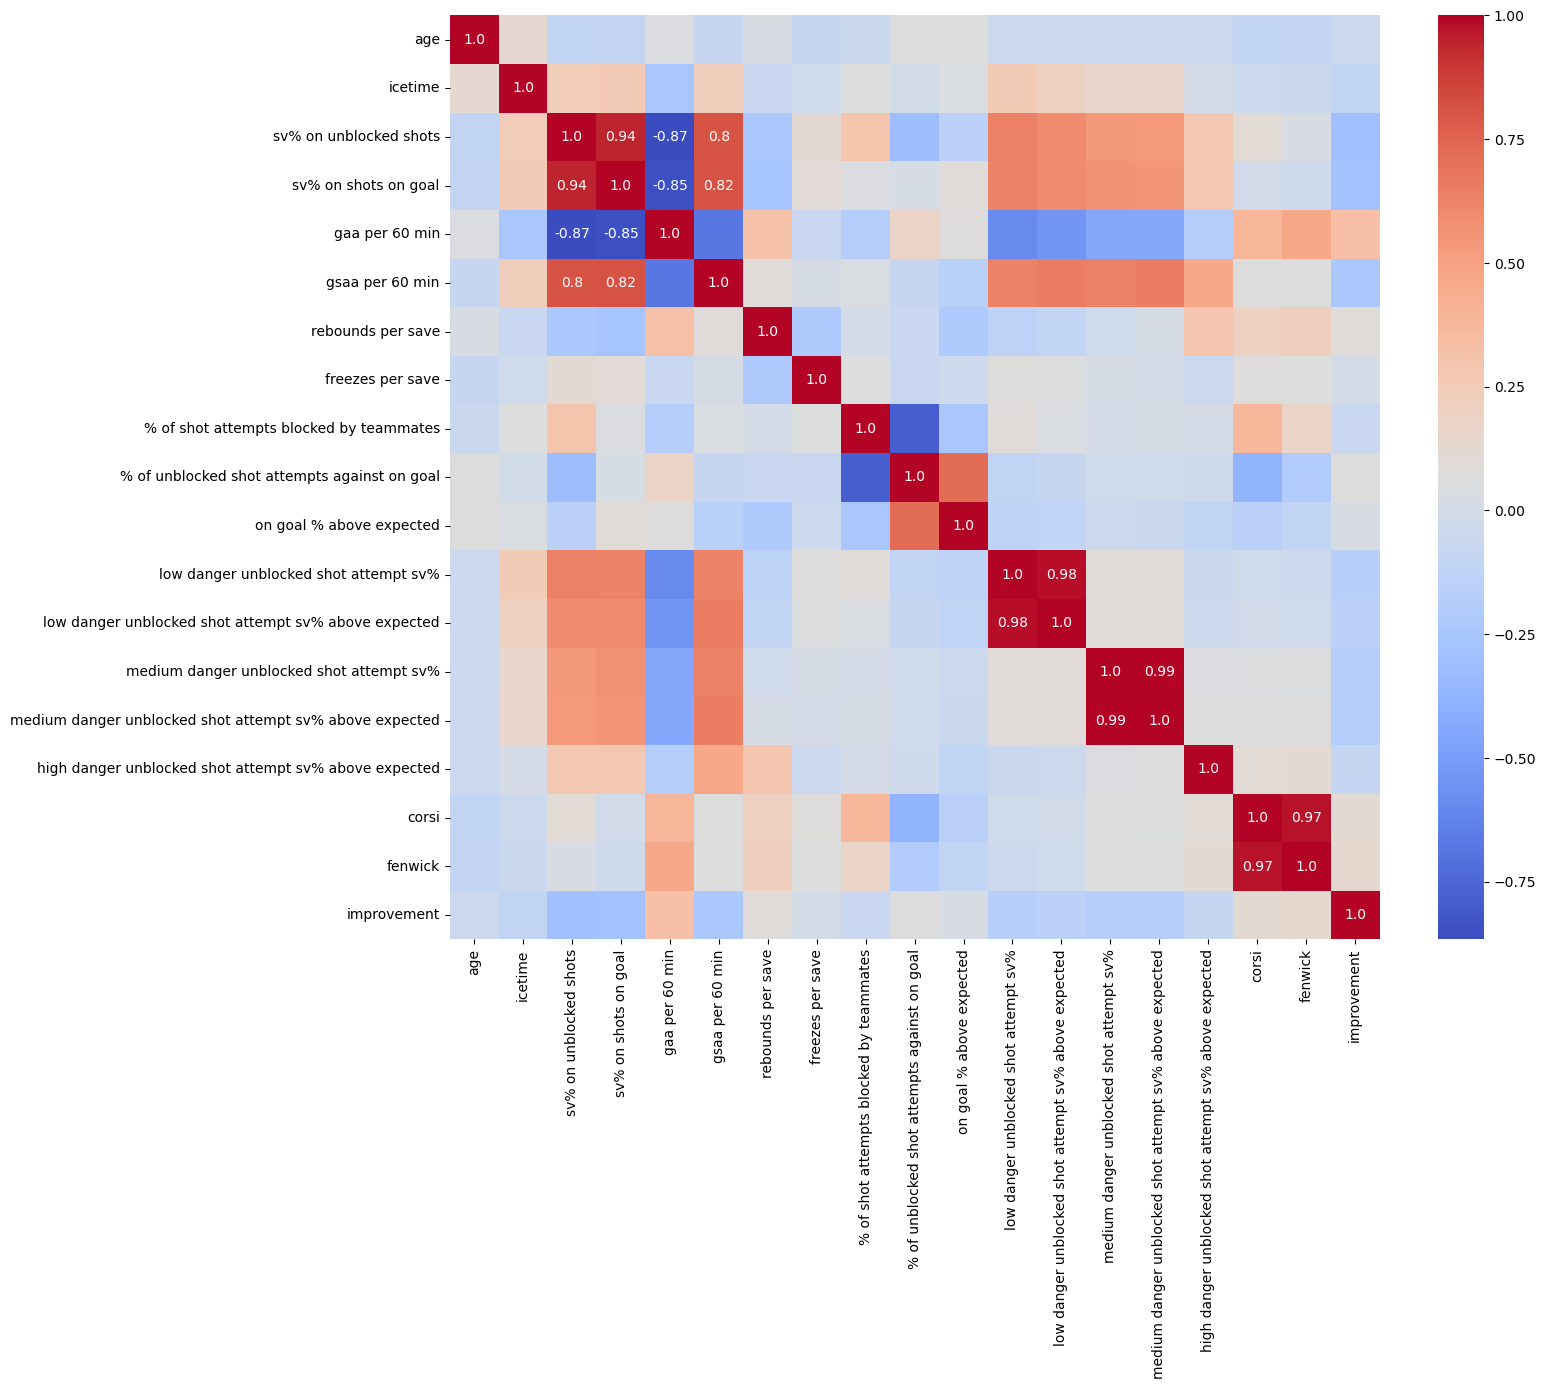

In [262]:
# Check correlations between the rest of features
correlation = df.drop(['season', 'name', 'team'], axis=1).corr()
# Make a heatmap with highlights on pairs of features with high correlations.
corr_annot = correlation.round(2)
corr_annot = corr_annot.astype(str)
corr_annot[corr_annot.astype(float).abs()<0.80] = ''
plt.figure(figsize=(15, 12))
sns.heatmap(correlation, annot=corr_annot, cmap='coolwarm', fmt='')

The heatmap revealed several other problems with the dataset: 
1. Save percentage on unblocked shots and shots on goal were positively correlated with goals saved above average and negatively correlated with goals against per 60 min. Additionally, save percentage for unblocked shots were extremely correlated with save percentage for shots on goal. We will just keep goals saved above average per 60 min.
2. The percentage of shots blocked by teammates and the percentage of unblocked shot attempts on goal were inversely related. Let's drop the percentage of unblocked shot attempts on goal.
3. Low and medium danger save percentages were highly positively correlated with their respective above average expectations. I suggest we drop our expectations.
4. Corsi and fenwick are highly correlated statistics. Let's drop fenwick and keep corsi as a proxy for offensive pressure.

In [264]:
# sv% on unblocked shots, gsaa per 60 min, % of unblocked shot attempts against on goal, 
# low danger unblocked shot attempt sv% above expected, medium danger unblocked shot attempt sv% above expected
df.drop(['sv% on unblocked shots', 'gsaa per 60 min', 'gaa per 60 min', 
         '% of unblocked shot attempts against on goal','low danger unblocked shot attempt sv% above expected',
         'medium danger unblocked shot attempt sv% above expected', 'fenwick'], axis=1, inplace=True)

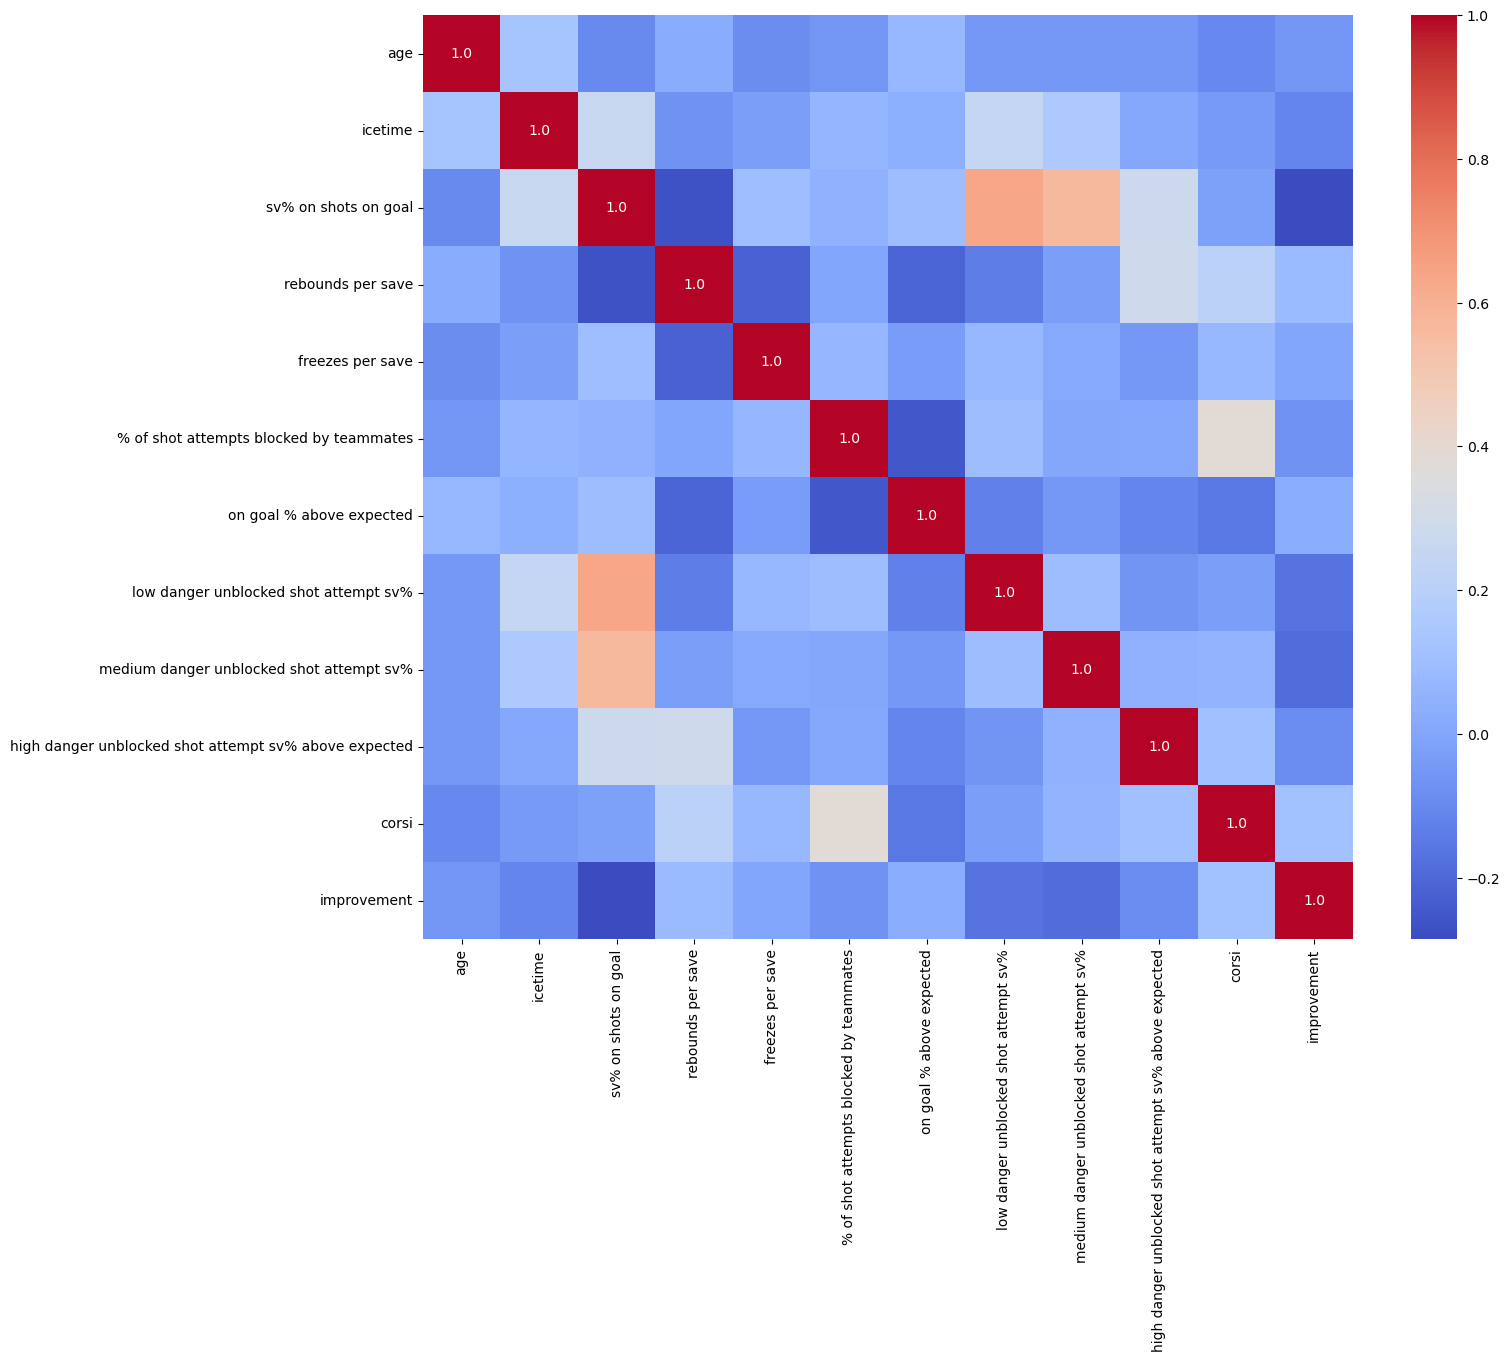

In [265]:
# Check correlations between the rest of features
correlation = df.drop(['season', 'name','team'], axis=1).corr()
# Make a heatmap with highlights on pairs of features with high correlations
corr_annot  = correlation.round(2)
corr_annot  = corr_annot.astype(str)
corr_annot[corr_annot.astype(float).abs()<0.8] = ''
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(correlation, annot=corr_annot, cmap='coolwarm', fmt='')
plt.savefig('heatmap.png')

In [268]:
df.head()

,season,name,age,team,icetime,sv% on shots on goal,rebounds per save,freezes per save,% of shot attempts blocked by teammates,on goal % above expected,low danger unblocked shot attempt sv%,medium danger unblocked shot attempt sv%,high danger unblocked shot attempt sv% above expected,corsi,improvement
0,2008,Craig Anderson,27,FLA,98154.0,0.924258,0.071982,0.266888,0.182874,0.021285,0.975585,0.884921,0.040395,75.811480,0.051340
1,2008,Carey Price,21,MTL,180336.0,0.905486,0.082482,0.237956,0.211768,0.015651,0.971975,0.878378,-0.067372,71.925739,-0.125235
2,2008,Chris Osgood,36,DET,159763.0,0.886589,0.071895,0.230626,0.159748,0.018897,0.963744,0.864780,-0.072437,53.742105,-0.260870
3,2008,Antero Niittymaki,28,PHI,108255.0,0.912355,0.086806,0.237269,0.200272,0.006053,0.967710,0.881517,0.040345,73.227103,-0.040179
4,2008,Ryan Miller,28,BUF,202395.0,0.918218,0.053440,0.226658,0.189764,0.016701,0.969649,0.886836,-0.031238,70.205292,0.017932


In [269]:
df.shape

(720, 15)

## 3. Check Distribution of Goalie Improvement Season-to-Season

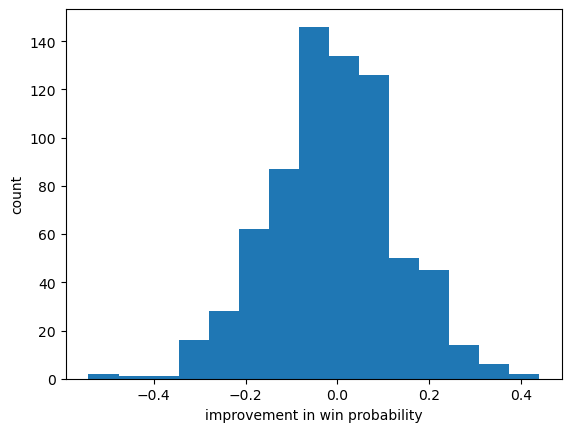

In [272]:
plt.hist(df['improvement'], bins=15)
plt.xlabel('improvement in win probability')
plt.ylabel('count')
plt.show()

The histogram demonstrates an approximately normal distribution centered around 0.

## 4. Feature Effects on Goalie Improvement

#### 4.1 Goalies are slow to develop. Peak improvement will be observed during mid to late 20s and then decline.

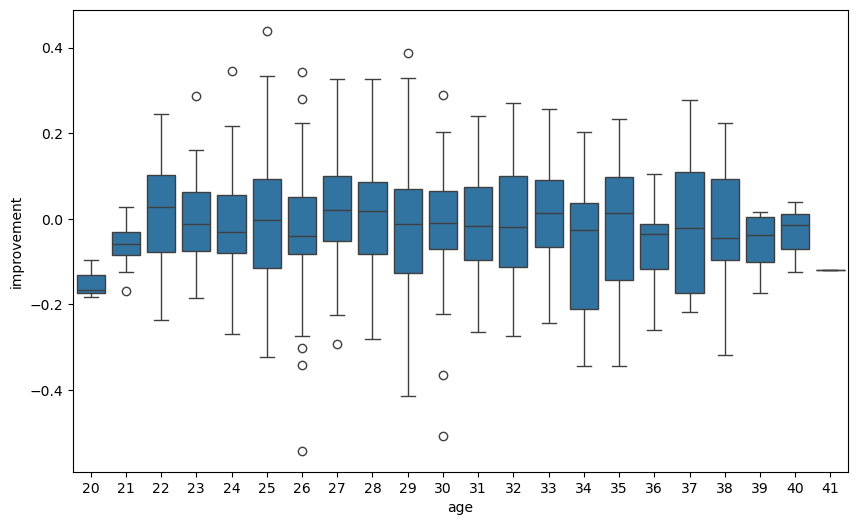

In [279]:
plt.figure(figsize=(10,6))
sns.boxplot(x='age', y='improvement', data=df)
plt.show()

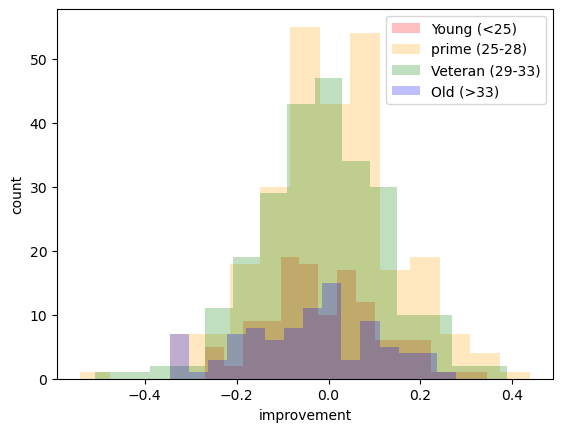

In [280]:
young     = df.loc[df['age']  <  25, 'improvement']
prime     = df.loc[(df['age'] >= 25) & (df['age'] < 29), 'improvement']
veteran   = df.loc[(df['age'] >= 29) & (df['age'] < 34), 'improvement']
old       = df.loc[df['age']  >= 34, 'improvement']
plot_data = [young, prime, veteran, old]
labels    = ['Young (<25)', 'prime (25-28)', 'Veteran (29-33)', 'Old (>33)']
colors    = ['red', 'orange', 'green', 'blue']
# Histogram
plt.figure()
for group, label, color in zip(plot_data, labels, colors):
    plt.hist(group, bins=15, alpha=0.25, label=label, color=color)
plt.xlabel('improvement')
plt.ylabel('count')
plt.legend()
plt.show()

In [282]:
young     = df.loc[df['age']  <  25, 'improvement']
prime     = df.loc[(df['age'] >= 25) & (df['age'] < 29), 'improvement']
veteran   = df.loc[(df['age'] >= 29) & (df['age'] < 34), 'improvement']
old       = df.loc[df['age']  >= 34, 'improvement']

len(young), len(prime), len(veteran), len(old)

(122, 263, 243, 92)

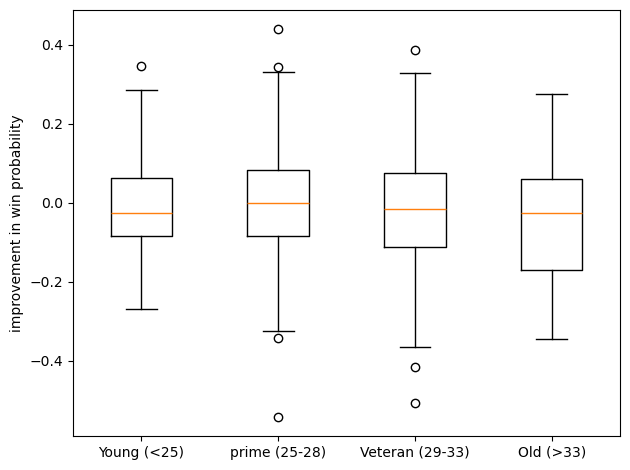

In [285]:
plt.boxplot(plot_data, labels=labels)
plt.ylabel('improvement in win probability')
plt.tight_layout()
plt.show()

In [287]:
# overall significance: anova
from scipy.stats import f_oneway
F, p = f_oneway(young, prime, veteran, old)
print(f'F statistic: {F}')
print(f'p-value:     {p}')

F statistic: 2.5504392330312426
p-value:     0.05465086606297726


In our ANOVA analysis, the p-value is not exactly less than .05, but there may still be evidence to suggest that at least one age group's mean improvement is significantly different from the others, leading us to reject that the means across all age groups are equal. We will now follow-up with Tukey's Honest Significant Difference (HSD) test to assess the significance of differences between pairs of age group means with respect to the increase in win probability during consecutive seasons. 

In [290]:
# post-hoc test: Tukey
from scipy.stats import tukey_hsd
res = tukey_hsd(young, prime, veteran, old)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.012     0.847    -0.051     0.027
 (0 - 2)      0.005     0.990    -0.035     0.044
 (0 - 3)      0.033     0.302    -0.016     0.082
 (1 - 0)      0.012     0.847    -0.027     0.051
 (1 - 2)      0.017     0.505    -0.015     0.049
 (1 - 3)      0.046     0.033     0.003     0.089
 (2 - 0)     -0.005     0.990    -0.044     0.035
 (2 - 1)     -0.017     0.505    -0.049     0.015
 (2 - 3)      0.028     0.333    -0.015     0.072
 (3 - 0)     -0.033     0.302    -0.082     0.016
 (3 - 1)     -0.046     0.033    -0.089    -0.003
 (3 - 2)     -0.028     0.333    -0.072     0.015



The p-value between goalies in their prime and those that are old does not exceed .05, so we reject the null hypothesis that they have the same means. The p-value of the comparison between all other age groups exceeds .05, so we accept the null hypothesis that there is not a significant difference between their mean chance of win improvement.

#### 4.2 If goalies play on better teams that have higher quality defense compared to the previous season, they will see an increase in improvement (win probability) for the next season.

The quality of a team's defense using our metrics from the dataset may be difficult to quantify directly. However, we can use the corsi statistic or percentage of shot attempts blocked by teammates as a proxy. Corsi may be a good indicator of the total amount of pressure or work that a goalie sees in a given game, while percentage of blocked shots can signify a defense's ability to be in good position.

- corsi_diff:
  - If goalie has next season data: corsiDiff_nextSeason(year) = corsi(year+1) - corsi(year)
  - If goalie missed a season: corsiDiff_nextSeason(year) = corsi(year+2) - corsi(year)
  - Note, we assume that a corsi_diff < 0 suggests an improvement in team defense.


- blocked_diff:
  - If goalie has next season data: blockedDiff_nextSeason(year) = blocked(year+1) - blocked(year)
  - If goalie missed a season: blockedDiff_nextSeason(year) = blocked(year+2) - blocked(year)
  - Note, we assume that a blocked_diff > 0 suggests an improvement in team defense.

In [295]:
# requires dataset with null values
df_wNull = pd.read_csv('./data/goalie_stats_wNull.csv')
df_wNull.drop(['goals against', 'games_played', 'war', 'win_prob', 'wins', 'saves on unblocked shot attempts', 'saves on shots on goal',
               'sv% above expected on unblocked shots', 'sv% above expected on shots on goal',
               'sv% on unblocked shots', 'gaa per 60 min', 'gsaa per 60 min', '% of unblocked shot attempts against on goal', 
               'low danger unblocked shot attempt sv% above expected','medium danger unblocked shot attempt sv% above expected', 'fenwick'], axis=1, inplace=True)
totalTime = df_wNull['icetime']
df_wNull.loc[:,'corsi']   = per_60_func(df_wNull.loc[:,'corsi'], time=totalTime)

In [297]:
df_wNull.head()

,season,name,age,team,icetime,sv% on shots on goal,rebounds per save,freezes per save,% of shot attempts blocked by teammates,on goal % above expected,low danger unblocked shot attempt sv%,medium danger unblocked shot attempt sv%,high danger unblocked shot attempt sv% above expected,corsi,improvement
0,2008,Craig Anderson,27,FLA,98154.0,0.924258,0.071982,0.266888,0.182874,0.021285,0.975585,0.884921,0.040395,75.811480,0.051340
1,2008,Carey Price,21,MTL,180336.0,0.905486,0.082482,0.237956,0.211768,0.015651,0.971975,0.878378,-0.067372,71.925739,-0.125235
2,2008,Chris Osgood,36,DET,159763.0,0.886589,0.071895,0.230626,0.159748,0.018897,0.963744,0.864780,-0.072437,53.742105,-0.260870
3,2008,Antero Niittymaki,28,PHI,108255.0,0.912355,0.086806,0.237269,0.200272,0.006053,0.967710,0.881517,0.040345,73.227103,-0.040179
4,2008,Karri Ramo,22,TBL,82314.0,0.895334,0.078873,0.257746,0.195506,0.020615,0.974453,0.850000,-0.134677,77.848240,NaN


In [299]:
# same function used before to calculate improvement
# situation 1: use corsi as a proxy for opposing team's offensive pressure
# situation 2: use percentage of blocked shots as proxy for quality of team's defense
def calculate_diff_with_next_year(df, col):
    diff = dict()
    for index, row in df.iterrows():
        season = row['season']
        # Check to see if stats for next year exists
        if season+1 in df['season'].values:
            next_year_value = df.loc[df['season'] == season + 1, col].iloc[0]
            diff[season] = float(next_year_value - row[col])
        elif season+2 in df['season'].values:
            next_year_value = df.loc[df['season'] == season + 2, col].iloc[0]
            diff[season] = float(next_year_value - row[col])
        else:
            diff[season] = np.nan
    return pd.Series(diff)

In [301]:
# calculate difference corsi statistic
corsi_diff          = df_wNull.groupby('name').apply(calculate_diff_with_next_year, col='corsi', include_groups=False)
corsi_diff          = pd.DataFrame(corsi_diff).reset_index()
corsi_diff.columns  = ['name', 'season', 'def_diff']
corsi_diff          = corsi_diff.merge(df[['name', 'season', 'improvement']], on=['season', 'name'], how='inner').sort_values(by='season').reset_index(drop=True)
corsi_diff.head()

,name,season,def_diff,improvement
0,Brian Boucher,2008,9.603350,-0.272727
1,Brian Elliott,2008,1.524223,0.011144
2,Josh Harding,2008,4.640101,0.202105
3,Nikolai Khabibulin,2008,18.313590,-0.206349
4,Niklas Backstrom,2008,-1.796607,-0.087793


In [302]:
# compute correlation coefficient between corsi_diff and improvement
res = np.corrcoef(corsi_diff.def_diff, corsi_diff.improvement)[0,1]
print(f'correlation coef: {round(res,2)}')

correlation coef: -0.15


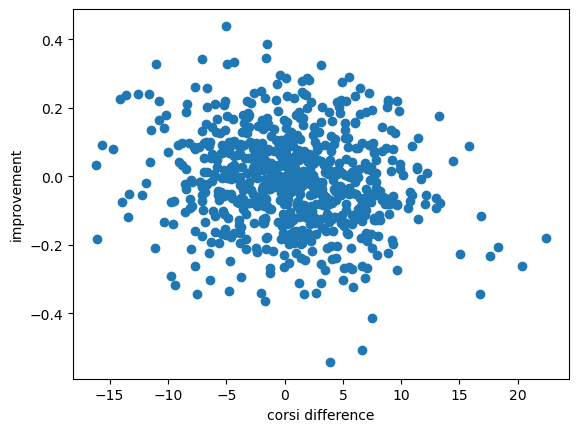

In [305]:
plt.scatter(corsi_diff['def_diff'], corsi_diff['improvement'])
plt.ylabel('improvement')
plt.xlabel('corsi difference')
plt.show()

By observation and by our correlation coefficient there exists a weak negative correlation between improvement in a goalie's defense as a function of their corsi statistic and a goalie's odds at improving their win percentage. 

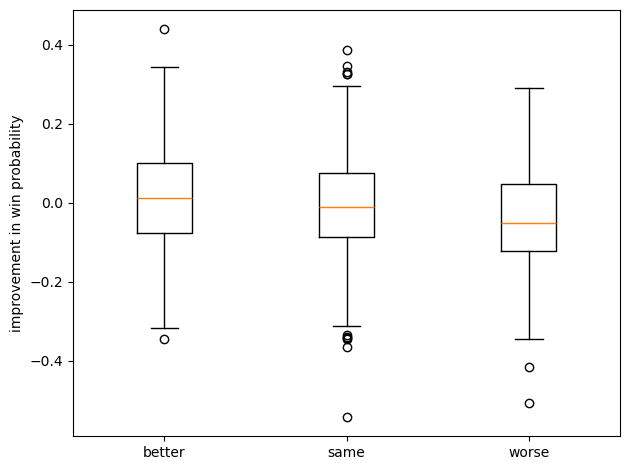

In [308]:
better     = corsi_diff.loc[corsi_diff['def_diff']<-5, 'improvement']
same       = corsi_diff.loc[(corsi_diff['def_diff']>=-5) & (corsi_diff['def_diff']<5), 'improvement']
worse      = corsi_diff.loc[corsi_diff['def_diff'] >= 5, 'improvement']

plot_data  = [better, same, worse]
labels     = ['better', 'same', 'worse']
plt.boxplot(plot_data, labels=labels)
plt.ylabel('improvement in win probability')
plt.tight_layout()
plt.show()

In [310]:
# overall significance: anova
from scipy.stats import f_oneway
F, p = f_oneway(better, same, worse)
print(f'F statistic: {F}')
print(f'p-value:     {p}')

F statistic: 4.642165276651434
p-value:     0.009928291497074105


In our ANOVA analysis, the p-value is less than .05, leading us to reject that the mean improvement across goalies clustered by their corsi difference between seasons are equal. We will now follow-up with Tukey's Honest Significant Difference (HSD) test to assess the significance of differences between pairs of corsi difference group means with respect to the increase in win probability during consecutive seasons. 

In [313]:
# post-hoc test: Tukey
from scipy.stats import tukey_hsd
res = tukey_hsd(better, same, worse)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.023     0.252    -0.011     0.057
 (0 - 2)      0.051     0.008     0.011     0.091
 (1 - 0)     -0.023     0.252    -0.057     0.011
 (1 - 2)      0.028     0.077    -0.002     0.058
 (2 - 0)     -0.051     0.008    -0.091    -0.011
 (2 - 1)     -0.028     0.077    -0.058     0.002



The p-value between goalies whose corsi declined and goalies whose corsi increased does not exceed .05, so we reject the null hypothesis that they have the same means. The p-value of the comparison between all other corsi difference groups exceeds .05, so we accept the null hypothesis that there is not a significant difference between their mean chance of win improvement.

In [316]:
# calculate difference in percentage of shots blocked by teammates 
blocked_diff          = df_wNull.groupby('name').apply(calculate_diff_with_next_year, col='% of shot attempts blocked by teammates', include_groups=False)
blocked_diff          = pd.DataFrame(blocked_diff).reset_index()
blocked_diff.columns  = ['name', 'season', 'def_diff']
blocked_diff          = blocked_diff.merge(df[['name', 'season', 'improvement']], on=['season', 'name'], how='inner').sort_values(by='season').reset_index(drop=True)
blocked_diff.head()

,name,season,def_diff,improvement
0,Brian Boucher,2008,0.029616,-0.272727
1,Brian Elliott,2008,0.007394,0.011144
2,Josh Harding,2008,0.037346,0.202105
3,Nikolai Khabibulin,2008,0.027341,-0.206349
4,Niklas Backstrom,2008,0.006995,-0.087793


In [318]:
# compute correlation coefficient between blocked_diff and improvement
res = np.corrcoef(blocked_diff.def_diff, blocked_diff.improvement)[0,1]
print(f'correlation coef: {round(res,2)}')

correlation coef: 0.14


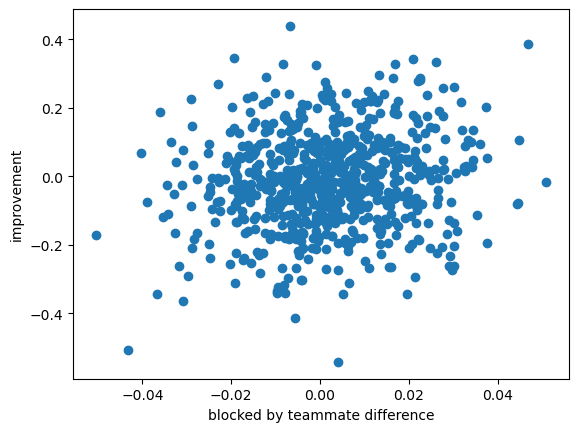

In [320]:
plt.scatter(blocked_diff['def_diff'], blocked_diff['improvement'])
plt.ylabel('improvement')
plt.xlabel('blocked by teammate difference')
plt.show()

By observation and by our correlation coefficient there exists a weak positive correlation between improvement in a goalie's defense as a function of their teammate's ability to block shots and a goalie's odds at improving their win percentage. 

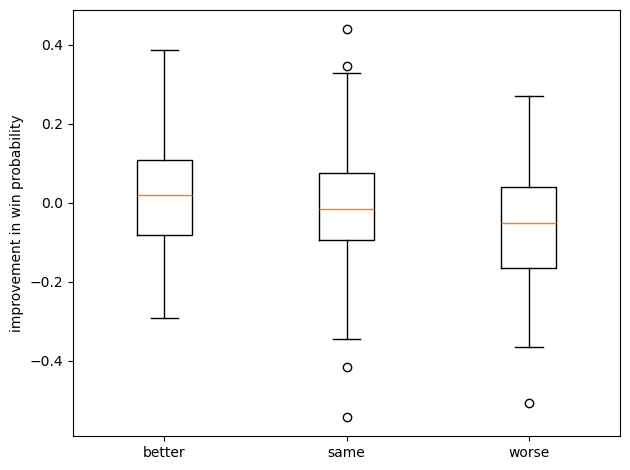

In [323]:
worse       = blocked_diff.loc[blocked_diff['def_diff']<-0.02, 'improvement']
same        = blocked_diff.loc[(blocked_diff['def_diff']>=-0.02) & (blocked_diff['def_diff']<0.02), 'improvement']
better      = blocked_diff.loc[blocked_diff['def_diff'] >= 0.02, 'improvement']

plot_data  = [better, same, worse]
labels     = ['better', 'same', 'worse']
plt.boxplot(plot_data, labels=labels)
plt.ylabel('improvement in win probability')
plt.tight_layout()
plt.show()

In [325]:
# overall significance: anova
from scipy.stats import f_oneway
F, p = f_oneway(better, same, worse)
print(f'F statistic: {F}')
print(f'p-value:     {p}')

F statistic: 4.829276035033318
p-value:     0.008254158389982095


In our ANOVA analysis, the p-value is less than .05, leading us to reject that the mean improvement across goalies clustered by percentage of blocked shots by teammates between seasons are equal. We will now follow-up with Tukey's Honest Significant Difference (HSD) test to assess the significance of differences between pairs of group means with respect to the increase in win probability during consecutive seasons. 

In [328]:
# post-hoc test: Tukey
from scipy.stats import tukey_hsd
res = tukey_hsd(better, same, worse)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.026     0.211    -0.010     0.062
 (0 - 2)      0.075     0.006     0.018     0.132
 (1 - 0)     -0.026     0.211    -0.062     0.010
 (1 - 2)      0.050     0.042     0.001     0.098
 (2 - 0)     -0.075     0.006    -0.132    -0.018
 (2 - 1)     -0.050     0.042    -0.098    -0.001



The p-value between goalies whose defense improved (as a function of blocked shots by teammates) and goalies whose defense declined is less than .05, so we reject the null hypothesis that they have the same means. Additionally, the p-value between goalies whose defense reamined the same and goalies whose defense declined is less than .05, so we reject the null hypothesis that they have the same means. However, the p-value between goalies whose defense improved and remained the same exceeds .05, so we accept the null hypothesis.

## 5. Data Exmport

In [332]:
df.to_csv('./data/model_goalie_stats.csv', index=False)